环境设定

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
from datetime import datetime

数据导入

In [2]:
# 基金数据导入
funds = pd.read_csv('funds_data.csv')
# Cahart模型因子数据导入
cahart = pd.read_csv('fivefactor_weekly.csv')

数据调整

In [3]:
# 时间类数据格式调整
funds['时间'] = pd.to_datetime(funds['时间'], format='%Y-%m-%d')
cahart['trdwk'] = pd.to_datetime(cahart['trdwk'], format='%Y-%m-%d')

In [4]:
# 基金回报率计算
funds['单位净值(初)']=funds.groupby('代码')['周单位净值(元)'].shift(1)
funds['净回报率'] = funds['周单位净值(元)']/funds['单位净值(初)'] - 1

In [5]:
# 取Cahart模型所需因子：市场风险因子（mkt_rf）、规模风险因子（smb）、账面市值比风险因子（hml）、\
#                    惯性/动量因子（umd）及无风险利率（rf）
c1 = cahart[(cahart['trdwk']>="2005-01-07")&(cahart['trdwk']<="2018-12-28")]
c2 = c1[['trdwk','mkt_rf','smb','hml','umd','rf']]
# 取基金净值有效时间段内数据
f = funds[(funds['时间']>='2005-01-07')&(funds['时间']<='2018-12-28')]
f = f.rename(columns = {'时间': 'trdwk'})
# 合并因子与基金净值
cmodel = pd.merge(f, c2, how='left', on='trdwk')

In [6]:
# 处理缺失值： 用上一个非缺失值填补
cmodel = cmodel.fillna(method='ffill')

In [7]:
# 调整合并后数据列名
cmodel = cmodel.drop(columns = ['周单位净值(元)', '单位净值(初)'])
cmodel = cmodel.rename(columns = {'代码': 'code', '简称': 'name', '净回报率': 'ri'})

In [8]:
cmodel.head()

,code,name,trdwk,ri,mkt_rf,smb,hml,umd,rf
0,510050.OF,50ETF,2005-01-07,-0.015060,-0.009569,0.016692,-0.001600,-0.026043,0.000428
1,510050.OF,50ETF,2005-01-14,0.002039,0.002330,0.006033,0.002732,-0.003396,0.000428
2,510050.OF,50ETF,2005-01-21,0.005086,-0.008801,0.004323,0.002299,-0.018932,0.000428
3,510050.OF,50ETF,2005-01-28,-0.012146,-0.022081,-0.017804,-0.002866,0.034744,0.000428
4,510050.OF,50ETF,2005-02-04,-0.105533,0.027939,-0.046164,0.001879,0.039884,0.000428


In [114]:
kmodel = cmodel.groupby("code").filter(lambda x: (len(x) > 5))

计算基金池内各基金真实Alpha的估计值（使用Cahart四因子OLS回归模型）

In [115]:
funds_list = kmodel.code.unique() # 基金清单

alpha = []
ta = []

for fund in funds_list:
    tmp_f = kmodel[kmodel['code'] == fund].reset_index(drop=True)
    X = tmp_f.loc[:, 'mkt_rf':'umd']
    Y = tmp_f.ri - tmp_f.rf
    
    true_ols = sm.OLS(Y, sm.add_constant(X)).fit()
    alpha_i = true_ols.params[0]
    ta_i = true_ols.tvalues[0]
    
    alpha.append(alpha_i) # 每只基金的真实Alpha(使用OLS回归后的估计值)
    ta.append(ta_i) # Alpha估计值的t-value

In [116]:
print("alpha:", alpha[:5],"\n","ta:",ta[:5])

alpha: [0.0007632565614886969, -0.0008554388280237516, -0.0010060216375671872, 0.00578850129619422, 0.006753065490592524] 
 ta: [1.2051567717981015, -1.3967463701635694, -1.1266762499223177, 0.9316754271468579, 1.2491767356564019]


## Kosowski模型（6.19 - 6.26)

1. 构建残差population 


In [117]:
# 多基金残差计算
def res_caculator(f):
    Y = f['ri']-f['rf']
    result = sm.OLS(Y, sm.add_constant(f.loc[:, ['mkt_rf', 'smb', 'hml', 'umd']])).fit() # 净值根据Cahart四因子做线性回归
    y_dot = result.fittedvalues # 线性方程拟合后计算净值预测值
    res = Y - y_dot # 净值与净值预测值相减形成残差
    
    # 记录回归方程中各参数取值
    coef = {}
    coef.update(alpha_dot = result.params[0], mkt_b = result.params[1], smb_b = result.params[2], hml_b = result.params[3],  umd_b = result.params[4])
    
    # 返回res计算后的单支基金数据及对应的四因子回归方程系数
    return (res, coef) 

2. 对残差population抽样，构建基金回报率伪时间序列

Kosowski模型创造基金回报率伪时间序列的方式是首先对残差数列进行有放回抽样，使用抽样残差数列，配合以下公式计算基金回报率伪时间序列：
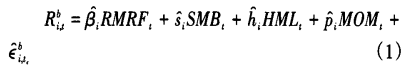

In [118]:
# 残差抽样方程
def k_sampling(res):
    # 最优时序分块采样
    #tseries = importr('tseries')
    tseries = importr('tseries')
    #tsbootstrap = robjects.r['tsbootstrap']()
    spl_res = tseries.tsbootstrap(res, nb = 1000, m = 1)
    spl_res0 = np.array(spl_res) # (715,1000)
    spl_res1 = spl_f0.T # 转置为（1000，715）
    
    return spl_res1

3. 得到回报率伪时间序列后，再通过CahartOLS回归得到伪Alpha

In [119]:
def k_fake_alpha_calculator(res, coef, cahart_factors):
    # 通过残差抽样计算伪回报率
    fake_y = cahart_factors['mkt_rf']*coef.get('mkt_b') + cahart_factors['smb']*coef.get('smb_b') + \
                   cahart_factors['hml']*coef.get('hml_b') + cahart_factors['umd']*coef.get('umd_b') + res
    
    # 得到伪回报率，通过伪回报率Cahart OLS回归得到基金伪Alpha.
    fake_result = sm.OLS(fake_y, sm.add_constant(cahart_factors.loc[:, 'mkt_rf':'umd'])).fit()
    fake_alpha = fake_result.params[0]
    fake_ta = fake_result.tvalues[0]
    
    return (fake_alpha, fake_ta)

In [120]:
funds1 = cmodel[cmodel['code'] == funds_list[0]].reset_index(drop=True) # 使用基金清单中第一支基金测试以上残差计算函数
plt1 = res_caculator(funds1)[0]
coefs = res_caculator(funds1)[1]

In [121]:
AllFundsFakeAlphas = []
AllFundsFakeTas = []
for f in funds_list:
    tmp_f = kmodel[kmodel['code'] == f].reset_index(drop=True)
    res_series = res_caculator(tmp_f)# EXP: len(res_series) = m, m为某基金合计数据点数量    
    f_coefs = res_series[1] 
    
    res_mat = k_sampling(res_series[0]) # EXP: res_mat.shape = (1000,m), m行*1000次/列
    
    OneFundFakeAlphas = []
    OneFundFakeTas = []
    for res in res_mat:
        OneFundFakeData = k_fake_alphaf_calculator(res, f_coefs, tmp_f)
        OneFundFakeAlphas.append(OneFundFakeData[0]) # EXP: len(OneFundFakeAlphas) = 1000
        OneFundFakeTas.append(OneFundFakeData[1]) # EXP: len(OneFundFakeTas) = 1000
         
    AllFundsFakeAlphas.append(OneFundFakeAlphas) # EXP: len(AllFundFakeAlphas) = 328, 基金池基金数量
    AllFundsFakeTas.append(OneFundsFakeTas) # EXP：len(AllFundFakeTas) = 328, 基金池基金数量

715
699
683
651
652
646
622
502
481
477
477
474
472
471
468
467
463
463
457
450
448
447
445
442
432
429
425
422
421
419
419
417
416
414
413
353
412
406
406
403
400
398
395
393
389
388
387
387
385
382
380
375
374
373
373
373
352
367
371
364
356
349
349
348
348
345
342
342
342
342
341
341
338
329
304
327
325
322
319
310
304
304
304
303
303
300
298
298
298
298
295
263
277
277
277
277
277
276
276
274
274
273
272
266
262
234
260
259
248
247
244
230
239
239
236
235
234
234
233
232
231
229
228
225
222
221
221
215
212
212
210
210
209
208
207
206
195
175
203
199
193
193
193
192
192
192
190
190
190
190
188
188
187
187
186
186
185
185
185
185
185
184
184
184
184
184
184
184
184
183
183
183
183
171
182
182
182
181
181
181
181
181
181
181
181
180
180
180
180
180
180
179
179
178
178
176
175
174
173
173
173
173
172
171
147
150
147
143
135
129
128
127
126
124
124
124
123
119
119
101
115
97
100
110
101
110
95
97
97
97
96
96
104
104
104
104
103
103
103
103
91
100
99
87
93
92
91
90
88
87
86
86
86
86
84
8

In [ ]:
AllFundsFakeAlpha_mat = np.array(AllFundsFakeAlphas).T # EXP: AllFundsFakeAlpha_mat.shape = (1000,328)
AllFundsFakeTa_mat = np.array(AllFundsFakeTas).T # EXP: AllFundsFakeTa_mat.shape = (1000,328)

4. 对所有基金的伪Alpha及其对应的t-value进行排序

In [49]:
def series_manipulator(alpha, ta):
    # 将两个List合并到一起，按alpha排序
    alpha = alpha.reshape(len(alpha),1)
    ta = ta.reshape(len(ta),1)

    one_fund_array = np.hstack([alpha, ta])
    one_fund_array = one_fund_array[np.argsort(one_fund_array[:,0]),:]
    
    # 将排好序的alpha和其t-value分开，变成两个二维数组
    one_fund_list = np.hsplit(one_fund_array,2)
    
    return one_fund_list  

In [ ]:
sorted_alpha = []
sorted_ta = []
for a,ta in zip(AllFundsFakeAlpha_mat,AllFundsFakeTa_mat):
    one_series_list = series_manipulator(a,ta)
    
    sorted_alpha.append(one_series_list[0]) # EXP: len(sorted_alpha)=1000
    sorted_ta.append(one_series_list[1]) # EXP: len(sorted_ta)=1000

K模型制表

1. 对真实Alpha进行排序，提取对应分位alpha的t-value

In [ ]:
Act = series_manipulator(alpha,ta)[1] # EXP: len(Act)=328

2. 对伪alpha数组计算t-value在每个alpha level的平均值

In [ ]:
Mean_Sim = np.array(sorted_ta).mean(axis=0) # EXP: shape = (328,)

3. 排列每个alpha level上的t-value

In [ ]:
k_ta_array = np.array(sorted_ta).reshape(len(funds_list),len(res_mat))
k_ta_dist = k_ta_array.T # EXP: k_ta_dist.shape = (328,1000)

# 产出每个alpha level上的%<Act值
perc_act = []
for i in range(len(funds_list)):
    lower = len(k_ta_dist[i][k_ta_dist[i]<ta[i]])/len(k_ta_dist[i])
    perc_act.append(lower)

In [ ]:
print(len(perc_act), perc_act[:10]) # EXP: len(perc_act) = len(funds_list) = 328, 且从小到大有序排列

In [ ]:
mydict = {'Act': Act,
          'Mean.Sim': Mean.Sim,
          'Perc_less_than_Act': perc_act
         }

In [ ]:
mydf = pd.DataFrame(mydict)
mydf.to_csv('k_frame.csv')

### —————————— Split Line ——————————— ###

OneFundFakeAlphas1 = [9,5,2,5,6,7,1,3] # 抽了8次/1000次
OneFundFakeAlphas2 = [3,5,1,6,7,2,3,5] 
AllFundsFakeAlphas = []
AllFundsFakeAlphas.append(OneFundFakeAlphas1) # 共两只基金/328支基金
AllFundsFakeAlphas.append(OneFundFakeAlphas2)

a_mat = np.array(AllFundsFakeAlphas).T
print(a_mat)
print(a_mat.shape)

a_mat[0]
t_mat = a_mat

t1 = series_manipulator(a_mat[5], t_mat[6])
t1[0]

for res in res_mat:
    res_mat_all.append(res)

print(res_mat_all)

a_mat.mean(axis=1)

,code,name,trdwk,ri,mkt_rf,smb,hml,umd,rf
0,510050.OF,50ETF,2005-01-07,-0.015060,-0.009569,0.016692,-0.001600,-0.026043,0.000428
1,510050.OF,50ETF,2005-01-14,0.002039,0.002330,0.006033,0.002732,-0.003396,0.000428
2,510050.OF,50ETF,2005-01-21,0.005086,-0.008801,0.004323,0.002299,-0.018932,0.000428
3,510050.OF,50ETF,2005-01-28,-0.012146,-0.022081,-0.017804,-0.002866,0.034744,0.000428
4,510050.OF,50ETF,2005-02-04,-0.105533,0.027939,-0.046164,0.001879,0.039884,0.000428
...,...,...,...,...,...,...,...,...,...
710,510050.OF,50ETF,2018-11-30,0.011443,0.004224,-0.007582,-0.000832,0.003726,0.000286
711,510050.OF,50ETF,2018-12-07,-0.018990,0.009998,0.009017,-0.000793,-0.012295,0.000286
712,510050.OF,50ETF,2018-12-14,-0.003295,-0.006201,-0.016902,0.000253,0.024137,0.000286
713,510050.OF,50ETF,2018-12-21,-0.048347,-0.031615,0.017655,0.008353,-0.005347,0.000286


In [68]:
res = res_caculator(funds1)[0]

In [70]:
type(res)

pandas.core.series.Series

In [122]:
test = np.random.random((1000,8))

In [123]:
len(test)

1000